In [1]:
import torch
import numpy as np 
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from transformers import PretrainedConfig

In [2]:

class LMConfig(PretrainedConfig):
    """ 
    配置类
    """
    def __init__(
        self,
        
        max_seq_len: int = 512,#最大seq长度
        dim:int = 512, #embedding 维度  atten输入总维度
        

        n_layers: int =8, # 多少层

        n_heads: int  = 16, # 16个头 #每个head dim为 dim//n_heads
        n_kv_heads: int = 8, # 8个 kv头 ，（这里也就是说有8个组，每两个Query head共享一个kv）
        
        intermediate_size: int=None,  # mlp中间的 hidden_dim

        norm_eps: float=1e-5, # RmsNorm
        dropout: float=0.0,
        
        flash_atten: bool=True, # 是否使用flash attention

        **kwargs,
    ):
        super().__init__(**kwargs)

        self.n_layers = n_layers
        self.max_seq_len = max_seq_len
        self.dim = dim
        self.n_heads =  n_heads
        self.n_kv_heads = n_kv_heads 
        self.intermediate_size=intermediate_size 
        self.norm_eps = norm_eps 
        self.dropout=dropout

        self.flash_atten = flash_atten 



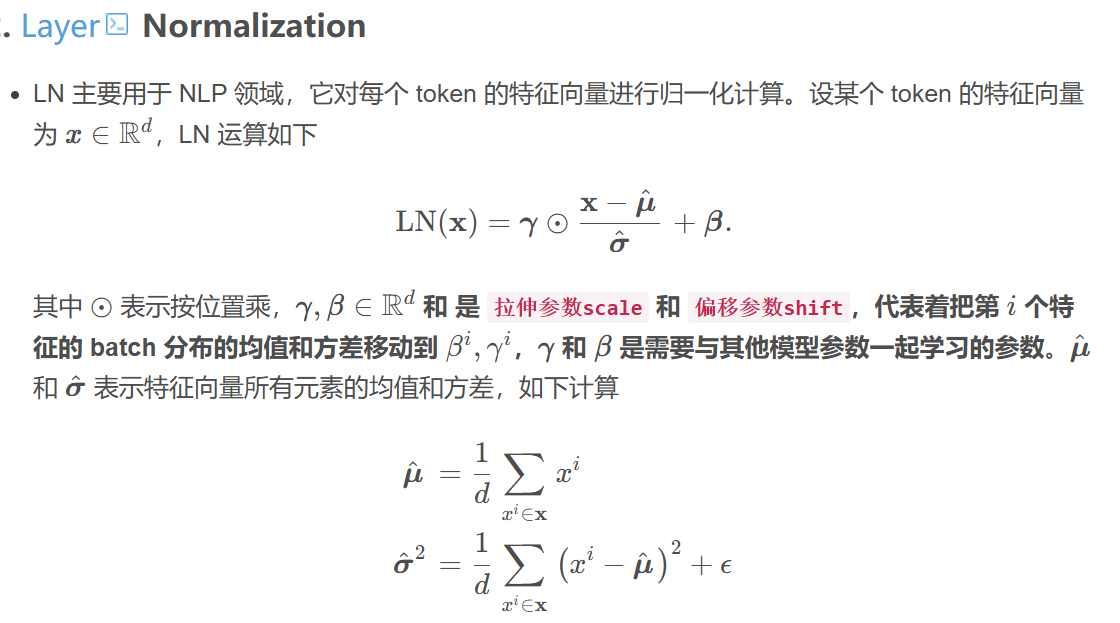

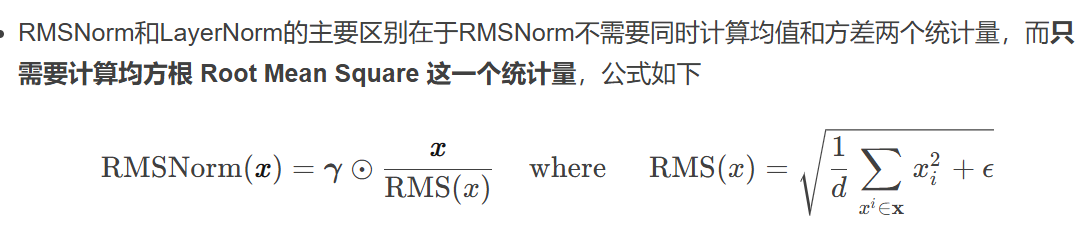

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, args:LMConfig):
        super().__init__()

        self.hidden_size = args.dim 
        self.weight = nn.Parameter(torch.ones(self.hidden_size))
        self.variance_epsion = args.norm_eps
    def forward(self,hidden_state):
        # (bs, seq, dim)
        # dtype（数据类型）
        input_dtype = hidden_state.dtype
        hidden_state = hidden_state.to(torch.float32)
        variance = hidden_state.pow(2).mean(-1, keepdim=True)
        hidden_state = hidden_state * torch.rsqrt(variance + self.variance_epsion)
        return self.weight * hidden_state.to(input_dtype)
        
        

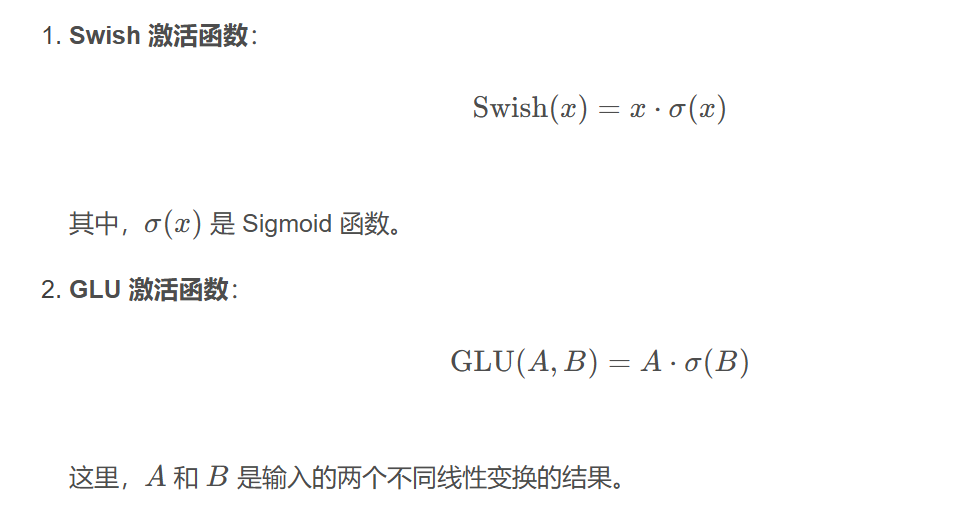

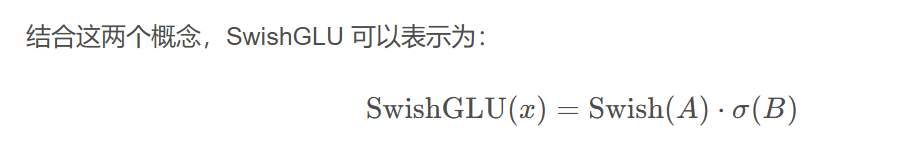

In [ ]:
class MLP(nn.Module):
    def __init__(self, args: LMConfig):
        super().__init__()
        self.hidden_size = args.dim 
        self.intermediate_size = args.intermediate_size
        self.act_fn = F.silu
        self.dropout = args.dropout

        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size,bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size,bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size,bias=False)
        self.dropout = nn.Dropout(args.dropout)
    def forward(self,x):
        inter = self.act_fn(self.gate_proj(x))*self.up_proj(x)
        return self.dropout(self.down_proj(inter))
        


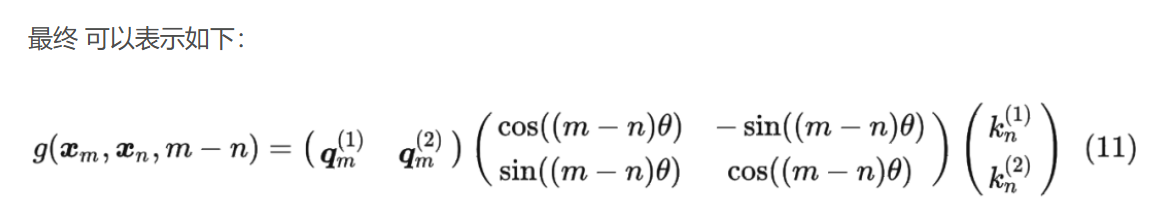
 
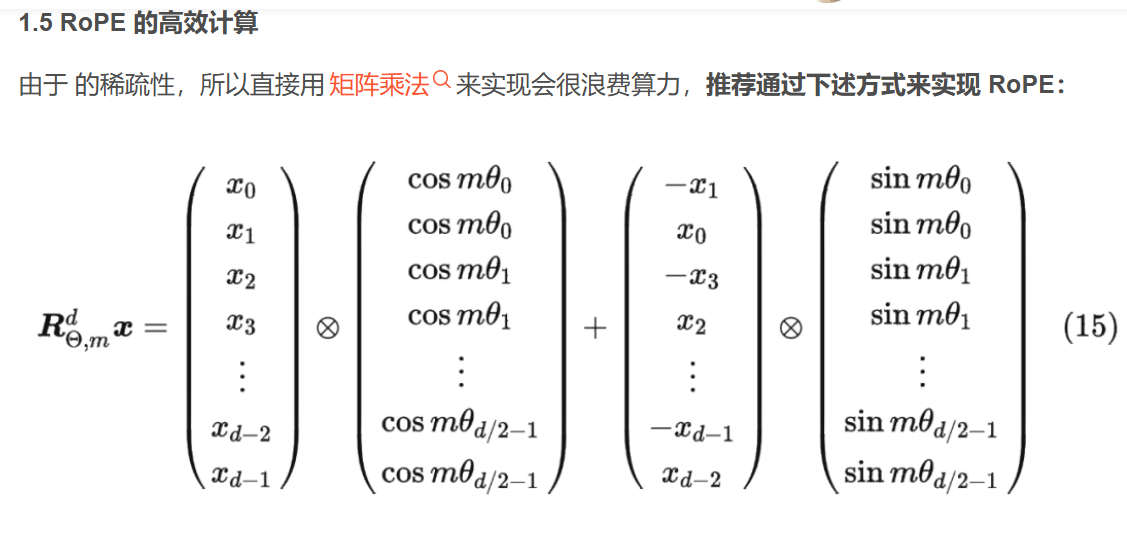

In [ ]:
class RotaryEmbedding(nn.Module):

    def __init__(self,args: LMConfig, base=10000.0):
        
        super().__init__()
        self.dim = args.dim
        self.max_position_embeddings = args.max_seq_len
        self.base = base

        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim,2, dtype=torch.int64)).float().to(args.device) / self.dim)
        self.reigister_buffer("inv_freq",inv_freq,persistent=False)
        

In [ ]:
class Attention(nn.Module):
    def __init__(self, args:LMConfig):
        super().__init__()

        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        self.n_heads = args.n_heads 
        assert args.n_heads % args.n_kv_heads ==0 , "group error"

        self.n_local_heads = self.n_heads
        self.n_local_kv_heads = self.n_kv_heads
        self.n_rep = self.n_local_heads // self.n_local_kv_heads 
        self.head_dim = args.dim // args.n_heads #每个head dim为 dim//n_heads

        self.wq = nn.Linear(args.dim, self.n_heads * self.head_dim,bias = False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim,bias = False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim,bias = False)
        self.wo = nn.Linear(args.dim, args.dim,bias = False)

        self.k_cache, self.v_cache = None, None
        self.atten_dropout = nn.Dropout(args.dropout)
        self.resid_dropout = nn.Dropout(args.dropout) 
        self.dropout = args.dropout 
        #  Flash Attention requires PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention') and args.flash_atten 

        mask = torch.full((1,1,args.max_seq_len,args.max_seq_len),float("-inf"))
        mask = torch.triu(mask,diagonal=1)
        # buffer中的tensor可以理解为模型的常数
        # 只有buffers() 和 parameters()中的属性可以被state_dict保存
        # persistent=False， 不需要保存到state_dict中去
        self.register_buffer("mask", mask, persistent=False)
        
    def forward(self,x, poc_cis, kv_cache=False):
        # x (bs,sq_len,dim)
        bsz, seqlen, _ = x.shape

        xq,xk,xv = self.wq(x), self.wk(x), self.wv(x)
        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        # 旋转位置编码  相对位置
        xq, xk = apply_rotary_emb(xq,xk,poc_cis)

        # kv_cache
        if kv_cache and self.eval():
            if seqlen == 1 and all(cache is not None for cache in (self.k_vavhe,self.v_cache)):
                xk = torch.cat(())
        


